In [1]:
import uproot as up
import numpy as np
import time
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from multiprocessing import Pool
import multiprocessing

tf.device('GPU:4')
sys.path.append('/software/pc24403/tfpcbpggsz/amp')
from PyD0ToKSpipi2018 import *

Kspipi = PyD0ToKSpipi2018()
Kspipi.init()
print('INFO: Loading the amplitude model')




INFO: Loading the amplitude modelD0ToKSpipi2018 ==> Initialization !



In [2]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=2):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/lhcb_toy_{decay}_{index}_CPrange.root:BplusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_sig_{index}.root:Bplus_DalitzEventList'

        else:
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/oy/mass_fit/add_sw/lhcb_toy_{decay}_{index}.root:BminusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_sig_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.Amp_PFT(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp='sig')
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p3_np[i], p2_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p2bar_np[i], p3bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=2, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/add_sw/lhcb_toy_{decay}_{index}_CPrange.root:BplusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            #file_name = f'/software/pc24403/PCBPGGSZ/outputs/oy/mass_fit/add_sw/lhcb_toy_{decay}_{index}.root:BminusDalitzEventList'
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names, '(B_M>5150) & (B_M<5800)')
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [3]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp')

mc_path = '/shared/scratch/pc24403/amp'

amp_Data_dk_dd_p, ampbar_Data_dk_dd_p = getAmp('b2dk_DD', 'p')
amp_Data_dk_dd_m, ampbar_Data_dk_dd_m = getAmp('b2dk_DD', 'm')

amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')


Amplitude for b2dk_DD loaded in 4.51087498664856 seconds
Amplitude for b2dk_DD loaded in 4.299301385879517 seconds


# Prepare Mass PDF

In [4]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
from massshape import *


def Gaussian(m, mu, sigma):
    _pi = tf.constant(np.pi, dtype=tf.float64)

    return (tf.math.exp(-0.5*((m-mu)/sigma)**2))/(sigma*tf.math.sqrt(2*_pi))
def preparePdf(Bu_M, varDict, mode='b2dk_LL'):
    '''
    Import constructed data sets and construct PDFs with RooFit functions.
    PDFs and data sets are saved together in a new RooWorkspace

    Args:
        configDict: a dictionary containing the values of PDF shape parameters
        year: which subset of data to fit, can be any single year of data taking,
              or 'Run1', 'Run2', 'All'.
    ''' 

    pdfList = {}

    print('--- Constructing signal pdfs...')
    varDict['DD_dk_Gauss_frac'] = 1 - varDict['DD_dk_Cruijff_frac']
    varDict['DD_dpi_Gauss_frac'] = 1- varDict['DD_dpi_Cruijff_frac']
    varDict['LL_dk_Gauss_frac'] = 1 - varDict['LL_dk_Cruijff_frac']
    varDict['LL_dpi_Gauss_frac'] = 1 - varDict['LL_dpi_Cruijff_frac']

    pdf_sig_Cruijff_DK_KsPiPi_DD  = CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_DD    = Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_DD'])

    pdf_sig_Cruijff_DPi_KsPiPi_DD = CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'], varDict['sigma_dpi_DD'], varDict['DD_dpi_Cruijff_alpha_L'], varDict['DD_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_DD   = Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_DD'])
    pdf_sig_Cruijff_DK_KsPiPi_LL  = CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'], varDict['sigma_dk_LL'], varDict['LL_dk_Cruijff_alpha_L'], varDict['LL_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_LL    = Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dk_LL'])
    pdf_sig_Cruijff_DPi_KsPiPi_LL = CruijffExtended(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'], varDict['sigma_dpi_LL'], varDict['LL_dpi_Cruijff_alpha_L'], varDict['LL_dpi_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DPi_KsPiPi_LL   = Gaussian(Bu_M, varDict['signal_mean'], varDict['sigma_dpi_LL'])


    if mode == 'b2dk_LL':
        pdfList['sig'] = addPdf([pdf_sig_Cruijff_DK_KsPiPi_LL, pdf_sig_Gauss_DK_KsPiPi_LL], [varDict['LL_dk_Cruijff_frac'], varDict['LL_dk_Gauss_frac']])
    elif mode == 'b2dpi_LL':
        pdfList['sig'] = addPdf([pdf_sig_Cruijff_DPi_KsPiPi_LL, pdf_sig_Gauss_DPi_KsPiPi_LL], [varDict['LL_dpi_Cruijff_frac'], varDict['LL_dpi_Gauss_frac']])
    elif mode == 'b2dk_DD':
        pdfList['sig'] = addPdf([pdf_sig_Cruijff_DK_KsPiPi_DD, pdf_sig_Gauss_DK_KsPiPi_DD], [varDict['DD_dk_Cruijff_frac'], varDict['DD_dk_Gauss_frac']])
    elif mode == 'b2dpi_DD':
        pdfList['sig'] = addPdf([pdf_sig_Cruijff_DPi_KsPiPi_DD, pdf_sig_Gauss_DPi_KsPiPi_DD], [varDict['DD_dpi_Cruijff_frac'], varDict['DD_dpi_Gauss_frac']])    
 

    print('--- Constructing misID pdfs...')
    pdf_misid_CB1_DK_KsPiPi_LL = CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width1'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha1'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_LL = CBShape(Bu_M, varDict['LL_d2kspp_dpi_to_dk_misID_mean1'], varDict['LL_d2kspp_dpi_to_dk_misID_width2'], varDict['LL_d2kspp_dpi_to_dk_misID_alpha2'], varDict['LL_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB1_DK_KsPiPi_DD = CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width1'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha1'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    pdf_misid_CB2_DK_KsPiPi_DD = CBShape(Bu_M, varDict['DD_d2kspp_dpi_to_dk_misID_mean1'], varDict['DD_d2kspp_dpi_to_dk_misID_width2'], varDict['DD_d2kspp_dpi_to_dk_misID_alpha2'], varDict['DD_d2kspp_dpi_to_dk_misID_n1'])
    if mode == 'b2dk_LL':
        pdfList['misid'] = addPdf([pdf_misid_CB1_DK_KsPiPi_LL, pdf_misid_CB2_DK_KsPiPi_LL], [varDict['LL_d2kspp_dpi_to_dk_misID_frac1'], varDict['LL_d2kspp_dpi_to_dk_misID_frac2']])
    elif mode == 'b2dk_DD':
        pdfList['misid'] = addPdf([pdf_misid_CB1_DK_KsPiPi_DD, pdf_misid_CB2_DK_KsPiPi_DD], [varDict['DD_d2kspp_dpi_to_dk_misID_frac1'], varDict['DD_d2kspp_dpi_to_dk_misID_frac2']])
    elif mode == 'b2dpi_LL':
        pdfList['misid'] = CBShape(Bu_M, varDict['LL_dk_to_dpi_misID_mean1'], varDict['LL_dk_to_dpi_misID_width1'], varDict['LL_dk_to_dpi_misID_alpha1'], varDict['LL_dk_to_dpi_misID_n1'])
    elif mode == 'b2dpi_DD':
        pdfList['misid'] = CBShape(Bu_M, varDict['DD_dk_to_dpi_misID_mean1'], varDict['DD_dk_to_dpi_misID_width1'], varDict['DD_dk_to_dpi_misID_alpha1'], varDict['DD_dk_to_dpi_misID_n1']) 

    print('--- Constructing low-mass pdfs...')
    varDict['low_sigma_k_DD'] = varDict['low_sigma_pi_DD']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_k_LL'] = varDict['low_sigma_pi_LL']/varDict['low_sigma_pi_over_k_ratio']
    varDict['low_sigma_gamma_dk'] = varDict['low_sigma_gamma']/varDict['low_sigma_pi_over_k_ratio_gamma']

    # B2Dsth (missing pi)
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_LL'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bd_Dstarph_D0pi_dpi'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_pi_DD'], varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL  = HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD  = HORNSdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'],  varDict['low_b_Bu_Dstar0h_D0pi0_dk'],  varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL   = HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_LL'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD   = HORNSdini(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],   varDict['low_b_Bd_Dstarph_D0pi_dk'],   varDict['low_csi_pi'], varDict['low_global_shift'], varDict['low_sigma_k_DD'],  varDict['low_ratio_pi'], varDict['low_f_pi'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL = HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD = HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dk'], varDict['low_b_Bu_Dstar0h_D0pi0_dk'], varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL  = HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_LL'], varDict['s1pi_LL'], varDict['m2pi_LL'], varDict['s2pi_LL'], varDict['m3pi_LL'], varDict['s3pi_LL'], varDict['m4pi_LL'], varDict['s4pi_LL'], varDict['f1pi_LL'], varDict['f2pi_LL'], varDict['f3pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD  = HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dk'],  varDict['low_b_Bd_Dstarph_D0pi_dk'],  varDict['low_csi_pi'], varDict['m1pi_DD'], varDict['s1pi_DD'], varDict['m2pi_DD'], varDict['s2pi_DD'], varDict['m3pi_DD'], varDict['s3pi_DD'], varDict['m4pi_DD'], varDict['s4pi_DD'], varDict['f1pi_DD'], varDict['f2pi_DD'], varDict['f3pi_DD'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL = HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD = HORNSdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0pi0_dpi'], varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_LL  = HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_LL'], varDict['s1pi_pi_LL'], varDict['m2pi_pi_LL'], varDict['s2pi_pi_LL'], varDict['m3pi_pi_LL'], varDict['s3pi_pi_LL'], varDict['m4pi_pi_LL'], varDict['s4pi_pi_LL'], varDict['f1pi_pi_LL'], varDict['f2pi_pi_LL'], varDict['f3pi_pi_LL'])
    pdf_low_misID_Bd_Dstarph_D0pi_DPi_KsPiPi_DD  = HORNSdini_misID(Bu_M, varDict['low_a_Bd_Dstarph_D0pi_dpi'],  varDict['low_b_Bu_Dstar0h_D0pi0_dpi'], varDict['low_csi_pi'], varDict['m1pi_pi_DD'], varDict['s1pi_pi_DD'], varDict['m2pi_pi_DD'], varDict['s2pi_pi_DD'], varDict['m3pi_pi_DD'], varDict['s3pi_pi_DD'], varDict['m4pi_pi_DD'], varDict['s4pi_pi_DD'], varDict['f1pi_pi_DD'], varDict['f2pi_pi_DD'], varDict['f3pi_pi_DD'])
    # B2Dsth (missing photon) 
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma'],    varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL  = HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD  = HILLdini(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'],  varDict['low_b_Bu_Dstar0h_D0gamma_dk'],  varDict['low_csi_gamma'], varDict['low_global_shift'], varDict['low_sigma_gamma_dk'], varDict['low_ratio_gamma'], varDict['low_f_gamma'])
    # DK misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL = HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD = HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dk'], varDict['low_b_Bu_Dstar0h_D0gamma_dk'], varDict['low_csi_gamma'], varDict['m1ga'], varDict['s1ga'], varDict['m2ga'], varDict['s2ga'], varDict['m3ga'], varDict['s3ga'], varDict['m4ga'], varDict['s4ga'], varDict['f1ga'], varDict['f2ga'], varDict['f3ga'])
    # DPi misid
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL = HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])
    pdf_low_misID_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD = HILLdini_misID(Bu_M, varDict['low_a_Bu_Dstar0h_D0gamma_dpi'], varDict['low_b_Bu_Dstar0h_D0gamma_dpi'], varDict['low_csi_gamma'], varDict['m1ga_pi'], varDict['s1ga_pi'], varDict['m2ga_pi'], varDict['s2ga_pi'], varDict['m3ga_pi'], varDict['s3ga_pi'], varDict['m4ga_pi'], varDict['s4ga_pi'], varDict['f1ga_pi'], varDict['f2ga_pi'], varDict['f3ga_pi'])

    # B2Dhpi
    # DPi
    pdf_B2Dpipi_1_DPi_KsPiPi_LL = HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_1_DPi_KsPiPi_DD = HORNSdini(Bu_M, varDict['low_a_I_B2Dpipi'],  varDict['low_b_I_B2Dpipi'],  varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_I_B2Dpipi'],  varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_LL = HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_2_DPi_KsPiPi_DD = HORNSdini(Bu_M, varDict['low_a_II_B2Dpipi'], varDict['low_b_II_B2Dpipi'], varDict['low_csi_B2Dpipi'], varDict['low_global_shift'], varDict['low_sigma_II_B2Dpipi'], varDict['low_ratio_B2Dpipi'], varDict['low_f_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_LL   = addPdf([pdf_B2Dpipi_1_DPi_KsPiPi_LL, pdf_B2Dpipi_2_DPi_KsPiPi_LL], varDict['low_frac_B2Dpipi'])
    pdf_B2Dpipi_DPi_KsPiPi_DD   = addPdf([pdf_B2Dpipi_1_DPi_KsPiPi_DD, pdf_B2Dpipi_2_DPi_KsPiPi_DD], varDict['low_frac_B2Dpipi'])
    # DK
    pdf_B2DKpi_1_DK_KsPiPi_LL = HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_1_DK_KsPiPi_DD = HORNSdini(Bu_M, varDict['low_a_B2DKpi'], varDict['low_b_B2DKpi'], varDict['low_csi_B2DKpi'], varDict['low_global_shift'], varDict['low_sigma_B2DKpi'], varDict['low_ratio_B2DKpi'], varDict['low_f_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_LL = Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_2_DK_KsPiPi_DD = Gaussian(Bu_M, varDict['low_mu_B2DKpi'], varDict['low_sigma_gaus_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_LL   = addPdf([pdf_B2DKpi_1_DK_KsPiPi_LL, pdf_B2DKpi_2_DK_KsPiPi_LL], varDict['low_frac_B2DKpi'])
    pdf_B2DKpi_DK_KsPiPi_DD   = addPdf([pdf_B2DKpi_1_DK_KsPiPi_DD, pdf_B2DKpi_2_DK_KsPiPi_DD], varDict['low_frac_B2DKpi'])
    # DK misid
    pdf_low_misID_B2Dpipi_DK_KsPiPi_LL = HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])
    pdf_low_misID_B2Dpipi_DK_KsPiPi_DD = HORNSdini_misID(Bu_M, varDict['low_a_B2Dpipi_misID'], varDict['low_b_B2Dpipi_misID'], varDict['low_csi_B2Dpipi'], varDict['low_m1_B2Dpipi_misID'], varDict['low_s1_B2Dpipi_misID'], varDict['low_m2_B2Dpipi_misID'], varDict['low_s2_B2Dpipi_misID'], varDict['low_m3_B2Dpipi_misID'], varDict['low_s3_B2Dpipi_misID'], varDict['low_m4_B2Dpipi_misID'], varDict['low_s4_B2Dpipi_misID'], varDict['low_f1_B2Dpipi_misID'], varDict['low_f2_B2Dpipi_misID'], varDict['low_f3_B2Dpipi_misID'])

    # Bs pdf
    pdf_low_Bs2DKPi_DK_KsPiPi_LL = HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])
    pdf_low_Bs2DKPi_DK_KsPiPi_DD = HORNSdini(Bu_M, varDict['low_a_Bs2DKpi'], varDict['low_b_Bs2DKpi'], varDict['low_csi_Bs2DKpi'], varDict['low_global_shift'], varDict['low_sigma_Bs2DKpi'], varDict['low_ratio_Bs2DKpi'], varDict['low_f_Bs2DKpi'])

    if mode == 'b2dk_LL':
        pdfList['low_Bs2DKPi'] = pdf_low_Bs2DKPi_DK_KsPiPi_LL
    elif mode == 'b2dk_DD':
        pdfList['low_Bs2DKPi'] = pdf_low_Bs2DKPi_DK_KsPiPi_DD


    # Combine: with fractions
    if 'frac_low_Bu_Dstar0h_D0pi0_DPi' in varDict.keys():
        # Combine: DPi lowmass
        pdf_low_dpi_DPi_KsPiPi_LL = addPdf([pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL, pdf_B2Dpipi_DPi_KsPiPi_LL], [varDict['frac_low_Bu_Dstar0h_D0pi0_DPi'], varDict['frac_low_Bd_Dstarph_D0pi_DPi'], varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'], varDict['frac_low_B2Dpipi_DPi']])
        pdf_low_dpi_DPi_KsPiPi_DD = addPdf([pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD, pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD, pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD, pdf_B2Dpipi_DPi_KsPiPi_DD], [varDict['frac_low_Bu_Dstar0h_D0pi0_DPi'], varDict['frac_low_Bd_Dstarph_D0pi_DPi'], varDict['frac_low_Bu_Dstar0h_D0gamma_DPi'], varDict['frac_low_B2Dpipi_DPi']])
        # Combine: DK lowmass
        pdf_low_dk_DK_KsPiPi_LL = addPdf([pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_B2DKpi_DK_KsPiPi_LL], [varDict['frac_low_Bu_Dstar0h_D0pi0_DK'], varDict['frac_low_Bd_Dstarph_D0pi_DK'], varDict['frac_low_Bu_Dstar0h_D0gamma_DK'], varDict['frac_low_B2DKpi_DK']])
        pdf_low_dk_DK_KsPiPi_DD = addPdf([pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD, pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_B2DKpi_DK_KsPiPi_DD],[varDict['frac_low_Bu_Dstar0h_D0pi0_DK'], varDict['frac_low_Bd_Dstarph_D0pi_DK'], varDict['frac_low_Bu_Dstar0h_D0gamma_DK'], varDict['frac_low_B2DKpi_DK']])
        # Combine: DK misid
        pdf_low_misID_DK_KsPiPi_LL = addPdf([pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_misID_B2Dpipi_DK_KsPiPi_LL], [varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK'], varDict['frac_low_misID_Bd_Dstarph_D0pi_DK'], varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK'], varDict['frac_low_misID_B2Dpipi_DK']])
        pdf_low_misID_DK_KsPiPi_DD = addPdf([pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD, pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_misID_B2Dpipi_DK_KsPiPi_DD], [varDict['frac_low_misID_Bu_Dstar0h_D0pi0_DK'], varDict['frac_low_misID_Bd_Dstarph_D0pi_DK'], varDict['frac_low_misID_Bu_Dstar0h_D0gamma_DK'], varDict['frac_low_misID_B2Dpipi_DK']])
    # Combine: with ratios
    else:
        # Combine: DPi lowmass
        pdf_low_dst2dpi_DPi_KsPiPi_LL = addPdf([pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_LL, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_LL], varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_dst2dpi_DPi_KsPiPi_DD = addPdf([pdf_Bd_Dstarph_D0pi_DPi_KsPiPi_DD, pdf_Bu_Dstar0h_D0pi0_DPi_KsPiPi_DD], varDict['low_dpi_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_dpi_dst_DPi_KsPiPi_LL = addPdf([pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_LL, pdf_low_dst2dpi_DPi_KsPiPi_LL], varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_dpi_dst_DPi_KsPiPi_DD = addPdf([pdf_Bu_Dstar0h_D0gamma_DPi_KsPiPi_DD, pdf_low_dst2dpi_DPi_KsPiPi_DD], varDict['low_dpi_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_dpi_DPi_KsPiPi_LL     = addPdf([pdf_B2Dpipi_DPi_KsPiPi_LL, pdf_low_dpi_dst_DPi_KsPiPi_LL], varDict['low_dpi_ratio_b2drho_vs_b2dstpi'])
        pdf_low_dpi_DPi_KsPiPi_DD     = addPdf([pdf_B2Dpipi_DPi_KsPiPi_DD, pdf_low_dpi_dst_DPi_KsPiPi_DD], varDict['low_dpi_ratio_b2drho_vs_b2dstpi'])
        # Combine: DK lowmass
        pdf_low_dst2dpi_DK_KsPiPi_LL = addPdf([pdf_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL], varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) 
        pdf_low_dst2dpi_DK_KsPiPi_DD = addPdf([pdf_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD], varDict['low_dk_ratio_Bd_dst_vs_Bu_dst']) 
        pdf_low_dk_dst_DK_KsPiPi_LL  = addPdf([pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_dst2dpi_DK_KsPiPi_LL], varDict['low_dk_ratio_dst2dgam_vs_dst2dk'])
        pdf_low_dk_dst_DK_KsPiPi_DD  = addPdf([pdf_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_dst2dpi_DK_KsPiPi_DD], varDict['low_dk_ratio_dst2dgam_vs_dst2dk'])
        pdf_low_dk_DK_KsPiPi_LL      = addPdf([pdf_B2DKpi_DK_KsPiPi_LL, pdf_low_dk_dst_DK_KsPiPi_LL], varDict['low_dk_ratio_b2dkst_vs_b2dstk'])
        pdf_low_dk_DK_KsPiPi_DD      = addPdf([pdf_B2DKpi_DK_KsPiPi_DD, pdf_low_dk_dst_DK_KsPiPi_DD], varDict['low_dk_ratio_b2dkst_vs_b2dstk'])
        # Combine: DK misid
        pdf_low_misID_dst2dpi_DK_KsPiPi_LL = addPdf([pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_LL, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_misID_dst2dpi_DK_KsPiPi_DD = addPdf([pdf_low_misID_Bd_Dstarph_D0pi_DK_KsPiPi_DD, pdf_low_misID_Bu_Dstar0h_D0pi0_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_Bd_dst_vs_Bu_dst'])
        pdf_low_misID_dst_DK_KsPiPi_LL     = addPdf([pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_LL, pdf_low_misID_dst2dpi_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_misID_dst_DK_KsPiPi_DD     = addPdf([pdf_low_misID_Bu_Dstar0h_D0gamma_DK_KsPiPi_DD, pdf_low_misID_dst2dpi_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_dst2dgam_vs_dst2dpi'])
        pdf_low_misID_DK_KsPiPi_LL         = addPdf([pdf_low_misID_B2Dpipi_DK_KsPiPi_LL, pdf_low_misID_dst_DK_KsPiPi_LL], varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'])
        pdf_low_misID_DK_KsPiPi_DD         = addPdf([pdf_low_misID_B2Dpipi_DK_KsPiPi_DD, pdf_low_misID_dst_DK_KsPiPi_DD], varDict['low_dpi_to_dk_misID_ratio_b2drho_vs_b2dstpi'])

    if mode == 'b2dk_LL':
        pdfList['low'] = pdf_low_dk_DK_KsPiPi_LL
        pdfList['low_misID'] = pdf_low_misID_DK_KsPiPi_LL

    elif mode == 'b2dk_DD':
        pdfList['low'] = pdf_low_dk_DK_KsPiPi_DD
        pdfList['low_misID'] = pdf_low_misID_DK_KsPiPi_DD

    elif mode == 'dpi_LL':
        pdfList['low'] = pdf_low_dpi_DPi_KsPiPi_LL

    elif mode == 'dpi_DD':
        pdfList['low'] = pdf_low_dpi_DPi_KsPiPi_DD


    # combinatorial
    print('--- Constructing comb pdfs...')
    if mode == 'b2dk_LL':
        pdfList['comb'] = Exponential(Bu_M, varDict['comb_const_dk_d2kspp_LL'])
    elif mode == 'b2dk_DD':
        pdfList['comb'] = Exponential(Bu_M, varDict['comb_const_dk_d2kspp_DD'])
    elif mode == 'dpi_LL':
        pdfList['comb'] = Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_LL'])
    elif mode == 'dpi_DD':
        pdfList['comb'] = Exponential(Bu_M, varDict['comb_const_dpi_d2kspp_DD'])


    print('--- INFO: Writing to file...')
    return pdfList

In [5]:
def test(m, a, b, csi, shift, sigma, ratio_sigma, fraction_sigma):

    a_new = tf.cast(a, tf.float64)
    b_new = tf.cast(b, tf.float64)
    B_NEW = tf.cast((a_new + b_new) / 2.0, tf.float64)

    sigma2 = tf.cast(sigma * ratio_sigma, tf.float64)

    firstG1 = (2*(a_new-2*B_NEW+(m-shift))*sigma)/tf.math.exp((a_new-(m-shift)))
    return firstG1

# Illustration on the amplitude

In [6]:

from importlib.machinery import SourceFileLoader

config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%('config_cpfit_output_2.py')).load_module()
varDict = config_mass_shape_output.getconfig()
decay = 'DK_KsPiPi_DD'

#print yields
print('Yields:')
print('Sig: %.2f'%varDict['n_sig_%s'%decay])
print('MisID: %.2f'%varDict['n_misid_%s'%decay])
print('Low: %.2f'%varDict['n_low_%s'%decay])
print('Comb: %.2f'%varDict['n_comb_%s'%decay])
print('Low MisID: %.2f'%varDict['n_low_misID_%s'%decay])
print('Low Bs2DKPi: %.2f'%varDict['n_low_Bs2DKPi_%s'%decay])
sum_yields = varDict['n_sig_%s'%decay] + varDict['n_misid_%s'%decay] + varDict['n_low_%s'%decay] + varDict['n_comb_%s'%decay] + varDict['n_low_misID_%s'%decay] + varDict['n_low_Bs2DKPi_%s'%decay]
print('Sum: %.2f'%sum_yields)
sig_yield = varDict['n_sig_%s'%decay]/2

Bu_M_m = np.linspace(5150, 5800, amp_dk_dd_m.shape[1])
mode = 'b2dk_DD'
pdfs_m = preparePdf(Bu_M_m, varDict, mode)
Bu_M_p = np.linspace(5150, 5800, amp_dk_dd_p.shape[1])
mode = 'b2dk_DD'
pdfs_p = preparePdf(Bu_M_p, varDict, mode)


Yields:
Sig: 10706.31
MisID: 4019.96
Low: 434.39
Comb: 2965.24
Low MisID: 2515.03
Low Bs2DKPi: 257.70
Sum: 20898.64
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...


/software/pc24403/tfpcbpggsz/func/massshape.py:45: RuntimeWarning: overflow encountered in exp
  firstG1 = ((2*(a_new-2*B_NEW+(m-shift))*sigma)/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*sigma*sigma)) - (2*(b_new-2*B_NEW+(m-shift))*sigma)/np.exp((b_new-(m-shift))*(b_new-(m-shift))/(2*sigma*sigma))+ np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma)*erf((-a_new+(m-shift))/(np.sqrt(2)*sigma))  - np.sqrt(2*np.pi)*((B_NEW-(m-shift))*(B_NEW-(m-shift)) + sigma*sigma) * erf((-b_new+(m-shift))/(np.sqrt(2)*sigma)))/(2*np.sqrt(2*np.pi))
/software/pc24403/tfpcbpggsz/func/massshape.py:46: RuntimeWarning: overflow encountered in exp
  secondG1 = (((2*sigma*(a_new*a_new + B_NEW*B_NEW + a_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(a_new+(m-shift)) + 2*(sigma*sigma)))/np.exp((a_new-(m-shift))*(a_new-(m-shift))/(2*(sigma*sigma))) - (2*sigma*(b_new*b_new + B_NEW*B_NEW + b_new*(m-shift) + (m-shift)*(m-shift) - 2*B_NEW*(b_new + (m-shift)) + 2*(sigma*sigma)))/np.exp((b_new - (m-shi

--- Constructing comb pdfs...
--- INFO: Writing to file...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


In [7]:
def DeltadeltaD(A, Abar):
    var = np.angle(A*np.conj(Abar)) 

    return var

In [8]:
def prod_totalAmplitudeSquared_XY( Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdfs=[]):

    phase = DeltadeltaD(amp, ampbar)
    absA = tf.abs(amp)
    absAbar = tf.abs(ampbar)
    Nsig = x[4]


    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        rB2 = xPlus**2 + yPlus**2
        return (absA**2 * rB2  + absAbar **2  + 2 * (absA * absAbar) * (xPlus * tf.cos(phase) - yPlus * tf.sin(phase)))*pdfs['sig']*Nsig
    
    elif Bsign == -1:
        xMinus = x[2]
        yMinus = x[3]
        rB2 = xMinus**2 + yMinus**2

        return (absA**2  + absAbar **2 * rB2 + 2 * (absA * absAbar) * (xMinus * tf.cos(phase) + yMinus * tf.sin(phase)))*pdfs['sig']*Nsig

def prod(pdfs1=[], pdfs2=[]):
    pdfs = []
    for i in range(len(pdfs1)):
        pdfs.append(pdfs1[i]*pdfs2[i])
    return pdfs

def totalAmplitudeSquared_Integrated_crossTerm(A, Abar):
    '''
    This function calculates the total amplitude squared for the integrated decay, v0.1 only for MD fitted, no correction yet
    |A||Abar|cos(deltaD)
    |A||Abar|sin(deltaD)
    '''
    phase = DeltadeltaD(A, Abar)
    AAbar = tf.abs(A)*tf.abs(Abar)
    real_part = tf.math.reduce_mean(AAbar*tf.cos(phase))
    imag_part = tf.math.reduce_mean(AAbar*tf.sin(phase))

    return (real_part, imag_part)



def totalAmplitudeSquared_Integrated(Bsign=1, normA=1.1, normAbar=1.1, crossTerm=(0, 0), x=(0,0,0,0)):
    '''
    A^2 * rb^2 + Abar^2 + 2*|A||Abar| * rb * cos(deltaB + gamma + deltaD)

    A^2 + Abar^2 * rb^2 + 2*|A||Abar| * rb * cos(deltaB + gamma - deltaD)
    '''
    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        rB2 = xPlus**2 + yPlus**2

        return (normA * rB2 + normAbar + 2*(xPlus *crossTerm[0] - yPlus * crossTerm[1]))
    
    else:
        xMinus = x[2]
        yMinus = x[3]
        rB2 = xMinus**2 + yMinus**2

        return (normA + normAbar  * rB2 + 2*(xMinus *crossTerm[0] + yMinus * crossTerm[1]))



In [9]:
def l_dk_dd(Bsign=1, x=()):

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)


    prob_p = prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs_p)
    prob_m = prod_totalAmplitudeSquared_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, pdfs_m)



    l_data_p = (prob_p/normalisation_Bplus)
    l_data_m = (prob_m/normalisation_Bminus)
    if Bsign ==1:
        return l_data_p
    else:
        return l_data_m

In [10]:
x = (-0.0897, -0.011, 0.0586, 0.0688, 5358)
#prob = prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, pdfs)

prob_p = l_dk_dd(1, x)
prob_p = prob_p.numpy().flatten()
prob_m = l_dk_dd(-1, x)
prob_m = prob_m.numpy().flatten()

# Check with signal only

In [11]:
s12_data_p , s13_data_p, B_M_data_p = getMass_v2('b2dk_DD', 'p','sig')

s12, s13 = getMass('b2dk_DD_p', 'int')

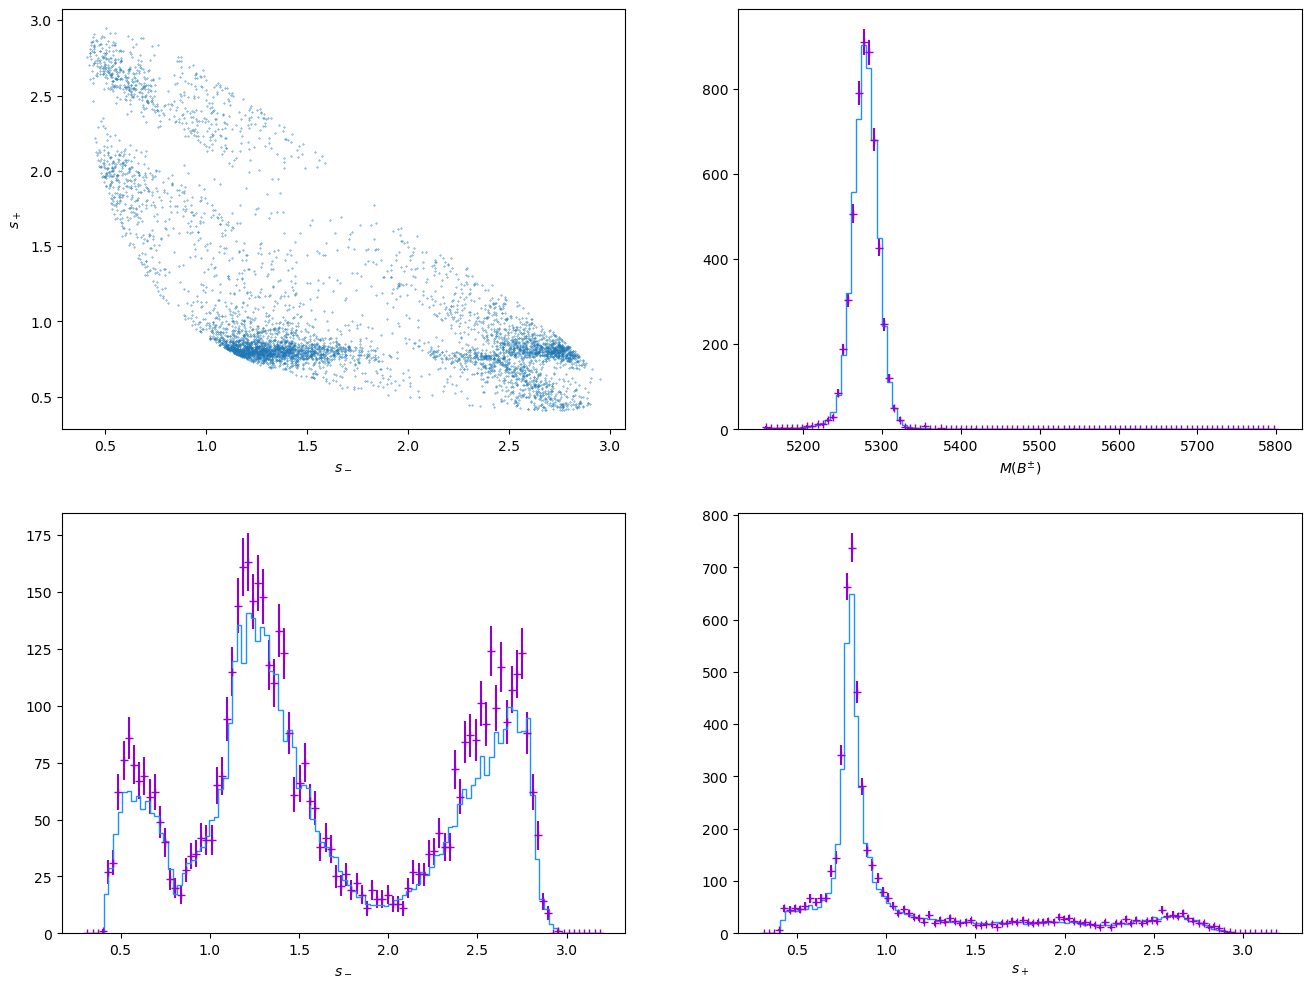

In [12]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data_p, s13_data_p,s=0.1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')


nbins = 100

bin_edges = np.linspace(5150, 5800, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(B_M_data_p, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax1.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax1.hist(Bu_M_p, bins=100, histtype='step', color='dodgerblue',weights=prob_p)
ax1.set_xlabel('$M(B^{\pm})$')


bin_edges = np.linspace(0.3, 3.2, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(s12_data_p, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax2.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax2.hist(s12, bins=100, histtype='step', color='dodgerblue',weights=prob_p)
ax2.set_xlabel('$s_-$')

bin_edges = np.linspace(0.3, 3.2, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(s13_data_p, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax3.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax3.hist(s13, bins=100, histtype='step', color='dodgerblue',weights=prob_p)
ax3.set_xlabel('$s_+$')

plt.show()

In [13]:
s12_data_m , s13_data_m, B_M_data_m = getMass_v2('b2dk_DD', 'm','sig')
s12, s13 = getMass('b2dk_DD_m', 'int')


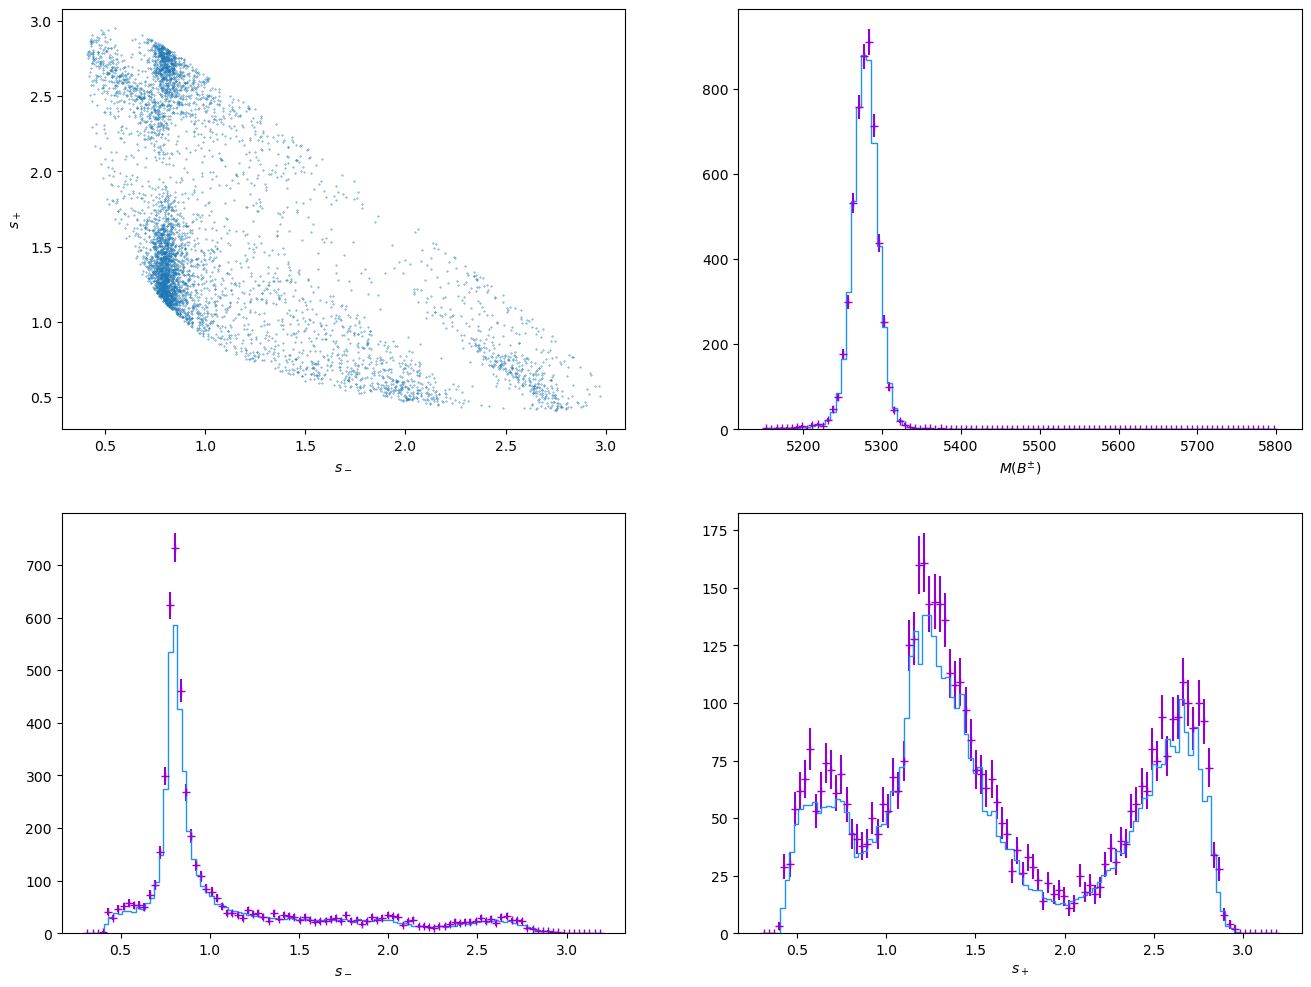

In [14]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data_m, s13_data_m,s=0.1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')


nbins = 100

bin_edges = np.linspace(5150, 5800, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(B_M_data_m, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax1.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax1.hist(Bu_M_m, bins=100, histtype='step', color='dodgerblue',weights=prob_m)
ax1.set_xlabel('$M(B^{\pm})$')


bin_edges = np.linspace(0.3, 3.2, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(s12_data_m, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax2.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax2.hist(s12, bins=100, histtype='step', color='dodgerblue',weights=prob_m)
ax2.set_xlabel('$s_-$')

bin_edges = np.linspace(0.3, 3.2, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(s13_data_m, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax3.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax3.hist(s13, bins=100, histtype='step', color='dodgerblue',weights=prob_m)
ax3.set_xlabel('$s_+$')

plt.show()

# A sig only prod fit

In [15]:
flat_B_M_m = np.linspace(5150, 5800, amp_Data_dk_dd_m.shape[1])
flat_B_M_p = np.linspace(5150, 5800, amp_Data_dk_dd_p.shape[1])
mode = 'b2dk_DD'
pdfs_m = preparePdf(flat_B_M_m, varDict, mode)
mode = 'b2dk_DD'
pdfs_p = preparePdf(flat_B_M_p, varDict, mode)

--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...


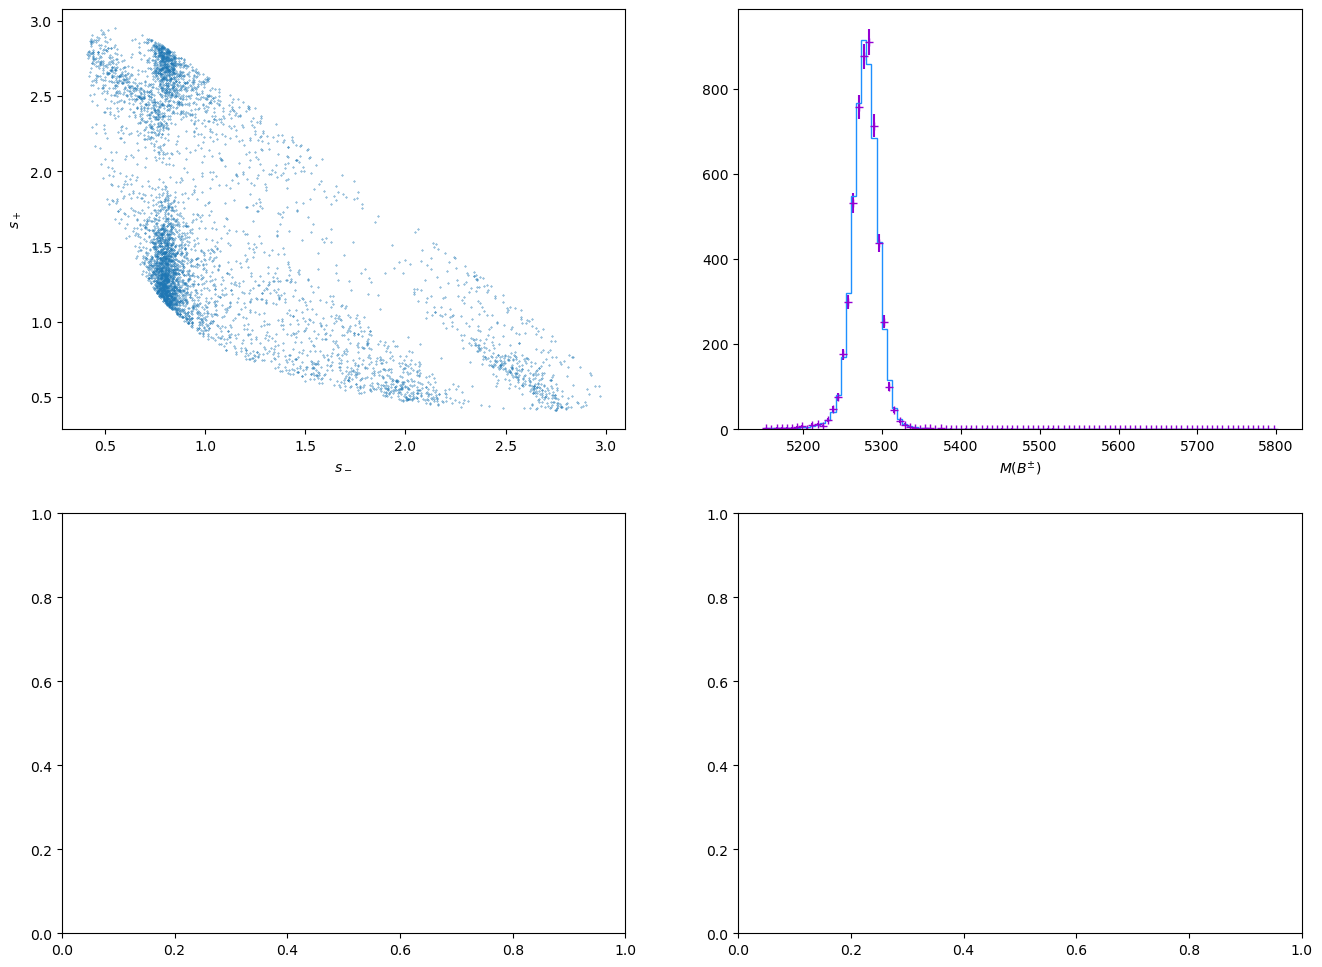

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data_m, s13_data_m,s=0.1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')


nbins = 100

bin_edges = np.linspace(5150, 5800, nbins+1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
counts, _ = np.histogram(B_M_data_m, bins=bin_edges)
# Calculate the standard deviation for the error bars
std_devs = np.sqrt(counts)
ax1.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet', label='Toy Data')
ax1.hist(flat_B_M_m, bins=100, histtype='step', color='dodgerblue',weights=pdfs_m['sig']*10735/2)
ax1.set_xlabel('$M(B^{\pm})$')
plt.show()



In [17]:
import iminuit
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

In [18]:
def addPdf(pdflist, frac, x):
    result = lambda x: 0
    if len(pdflist) != len(frac):
        if len(frac) ==1:
            result = frac[0]*pdflist[0] + (1-frac[0])*pdflist[1]

            return result(x)
        else:
            return None and print('The length of the list of pdfs and the list of fractions must be the same')
    
    else:
        for i in range(len(pdflist)):
            result = frac[i]*pdflist[i](x)
        return result(x)

sum_pdf = {}

pdf_sig_Cruijff_DK_KsPiPi_DD  = lambda B_M: CruijffExtended(B_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
pdf_sig_Gauss_DK_KsPiPi_DD    = lambda B_M: Gaussian(B_M, varDict['signal_mean'], varDict['sigma_dk_DD'])
sum_pdf['sig_m'] = lambda B_M: addPdf([pdf_sig_Cruijff_DK_KsPiPi_DD, pdf_sig_Gauss_DK_KsPiPi_DD], [0.5, 0.5], B_M)
pdf_sig_Cruijff_DK_KsPiPi_DD  = lambda B_M: CruijffExtended(B_M, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
pdf_sig_Gauss_DK_KsPiPi_DD    = lambda B_M: Gaussian(B_M, varDict['signal_mean'], varDict['sigma_dk_DD'])
sum_pdf['sig_p'] = lambda B_M: addPdf([pdf_sig_Cruijff_DK_KsPiPi_DD, pdf_sig_Gauss_DK_KsPiPi_DD], [0.5, 0.5], B_M)
pdf_tot = lambda B_M: addPdf([pdf_sig_Cruijff_DK_KsPiPi_DD(B_M), pdf_sig_Gauss_DK_KsPiPi_DD(B_M)], [0.5, 0.5], B_M)


In [20]:
def prod_totalAmplitudeSquared_XY_test(Bsign=1, amp=[], ampbar=[], x=(0,0,0,0,0), pdf=[]):

    phase = DeltadeltaD(amp, ampbar)
    absA = tf.abs(amp)
    absAbar = tf.abs(ampbar)
    Nsig = x[4]/2

    if Bsign == 1:
        xPlus = x[0]
        yPlus = x[1]
        rB2 = xPlus**2 + yPlus**2
        pdf_sig_Cruijff_DK_KsPiPi_DD  = CruijffExtended(B_M_data_p, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
        pdf_sig_Gauss_DK_KsPiPi_DD    = Gaussian(B_M_data_p, varDict['signal_mean'], varDict['sigma_dk_DD'])
        pdf_sum = Nsig* (varDict['DD_dk_Cruijff_frac']*norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_DD)+ varDict['DD_dk_Gauss_frac']*norm_pdf(pdf_sig_Gauss_DK_KsPiPi_DD))
        return (absA **2 * rB2 + absAbar**2 + 2 * (absA * absAbar) * (xPlus * tf.cos(phase) - yPlus * tf.sin(phase)))*norm_pdf(pdf_sum)
    else:
        xMinus = x[2]
        yMinus = x[3]
        rB2 = xMinus**2 + yMinus**2
        pdf_sig_Cruijff_DK_KsPiPi_DD  = CruijffExtended(B_M_data_m, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
        pdf_sig_Gauss_DK_KsPiPi_DD    = Gaussian(B_M_data_m, varDict['signal_mean'], varDict['sigma_dk_DD'])
        pdf_sum = Nsig* (varDict['DD_dk_Cruijff_frac']*norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_DD)+ varDict['DD_dk_Gauss_frac']*norm_pdf(pdf_sig_Gauss_DK_KsPiPi_DD))

        return (absA**2  + absAbar **2 * rB2 + 2 * (absA * absAbar) * (xMinus * tf.cos(phase) + yMinus * tf.sin(phase)))*norm_pdf(pdf_sum)


    
def nll_dk_dd(x=()):

    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)


    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)


    prob_p = prod_totalAmplitudeSquared_XY_test(1, amp_Data_dk_dd_p, ampbar_Data_dk_dd_p, x, pdfs_p)
    prob_m = prod_totalAmplitudeSquared_XY_test(-1, amp_Data_dk_dd_m, ampbar_Data_dk_dd_m, x, pdfs_m)

    N_tot = B_M_data_m.shape[1] + B_M_data_p.shape[1]

    l_data_p = (prob_p/normalisation_Bplus)
    l_data_m = (prob_m/normalisation_Bminus)


    ll_data_p = tf.math.log(l_data_p)
    ll_data_m = tf.math.log(l_data_m)
    print("NLL: ",tf.reduce_sum(-2*ll_data_p) + tf.reduce_sum(-2*ll_data_m))
    return (tf.reduce_sum(-2*ll_data_p) + tf.reduce_sum(-2*ll_data_m))

    


In [21]:
%%time
print('Exception yields',varDict['n_sig_DK_KsPiPi_DD'])
x = (0,0,0,0, varDict['n_sig_DK_KsPiPi_DD'])
with tf.device('GPU:4'):
    m = iminuit.Minuit(nll_dk_dd, x)
    m.fixed = [False, False, False, False, False]
    m.limits = [None, None, None, None, (varDict['n_sig_DK_KsPiPi_DD']*0.5, 1.5*varDict['n_sig_DK_KsPiPi_DD'])]
    mg = m.migrad()
    #mg = m.scipy()


Exception yields 10706.312639596192
NLL:  tf.Tensor(-16527.681502526822, shape=(), dtype=float64)
NLL:  tf.Tensor(-16512.568104694867, shape=(), dtype=float64)
NLL:  tf.Tensor(-16541.87449571, shape=(), dtype=float64)
NLL:  tf.Tensor(-16526.211569896434, shape=(), dtype=float64)
NLL:  tf.Tensor(-16529.142230947815, shape=(), dtype=float64)
NLL:  tf.Tensor(-16527.411316324025, shape=(), dtype=float64)
NLL:  tf.Tensor(-16527.210723931, shape=(), dtype=float64)
NLL:  tf.Tensor(-16527.687942271063, shape=(), dtype=float64)
NLL:  tf.Tensor(-16527.66718110416, shape=(), dtype=float64)
NLL:  tf.Tensor(-16535.879680918493, shape=(), dtype=float64)
NLL:  tf.Tensor(-16518.477748206016, shape=(), dtype=float64)
NLL:  tf.Tensor(-16528.54652805211, shape=(), dtype=float64)
NLL:  tf.Tensor(-16526.80642212603, shape=(), dtype=float64)
NLL:  tf.Tensor(-16536.70250861434, shape=(), dtype=float64)
NLL:  tf.Tensor(-16518.00293156966, shape=(), dtype=float64)
NLL:  tf.Tensor(-16528.70112229423, shape=(), 

In [22]:
print(mg)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.674e+04                 │              Nfcn = 307              │
│ EDM = 3.87e-09 (Goal: 0.0002)    │           time = 44.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

# Simple Fit example to validate Mass

In [ ]:
M = np.array(B_M_data_m)
# bin it
w, xe = np.histogram(M, bins=100, range=[5150,5800])

# compute bin-wise density estimates
werr = w ** 0.5
cx = 0.5 * (xe[1:] + xe[:-1])
d = w 
derr = werr 

# define model and cost function
def model(x, par):

    pdf_sig_Cruijff_DK_KsPiPi_DD  = CruijffExtended(x, varDict['signal_mean'], varDict['sigma_dk_DD'], varDict['sigma_dk_DD'], varDict['DD_dk_Cruijff_alpha_L'], varDict['DD_dk_Cruijff_alpha_R'], varDict['Cruijff_beta'])
    pdf_sig_Gauss_DK_KsPiPi_DD    = Gaussian(x, varDict['signal_mean'], varDict['sigma_dk_DD'])
    pdf_sum = par* (varDict['DD_dk_Cruijff_frac']*norm_pdf(pdf_sig_Cruijff_DK_KsPiPi_DD)+ varDict['DD_dk_Gauss_frac']*norm_pdf(pdf_sig_Gauss_DK_KsPiPi_DD))
    return par, par*norm_pdf(pdf_sum)


cost = ExtendedUnbinnedNLL(M, model)

# fit the model
m = Minuit(cost, (10000 ))

m.migrad()
m.hesse()





┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.886e+04                 │              Nfcn = 33               │
│ EDM = 6.85e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par  │  5.36e3   │  0.07e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────────┐
│     │      par │
├─────┼──────────┤
│ par │ 5.36e+03 │
└─────┴──────────┘

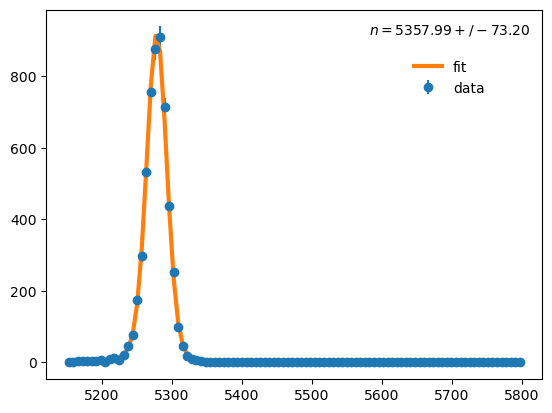

In [ ]:
# plot everything
result = m.values


plt.errorbar(cx, w, yerr=derr, fmt="o", label="data")
plt.plot(cx, model(cx, m.values)[1], lw=3,
         label="fit")
plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n");